In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from utils import create_model
import os
from configs import config
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from cropimage import Cropper

2023-09-01 18:00:21.510357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 18:00:22.056472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/anaconda3/envs/MedicalImageClassification/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/anaconda3/envs/MedicalImageClassification/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` fr

In [3]:
import cv2


def crop_images_in_directory(input_dir, output_dir):
    # Initialize the cropper
    cropper = Cropper()

    # Walk through the input directory
    for dirpath, dirnames, filenames in os.walk(input_dir):
        for filename in filenames:
            # Check if the file is an image (based on the extension)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                input_filepath = os.path.join(dirpath, filename)

                # Crop the image
                result = cropper.crop(input_filepath)

                # Create the corresponding output directory
                relative_path = os.path.relpath(dirpath, input_dir)
                output_folder_path = os.path.join(output_dir, relative_path)
                os.makedirs(output_folder_path, exist_ok=True)

                # Save the cropped image
                output_filepath = os.path.join(output_folder_path, filename)
                cv2.imwrite(output_filepath, result)


# Usage
input_folder = "Dataset/extracted/"
output_folder = "Dataset/cropped"
crop_images_in_directory(input_folder, output_folder)

RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

# Quantitative Results

In [14]:
model_filename = "2023-09-01 14:15:55.294334_vgg16_e100_lr1e-06_bs128_dr0.2"
history = pd.read_csv(f"runs/{model_filename}.csv")

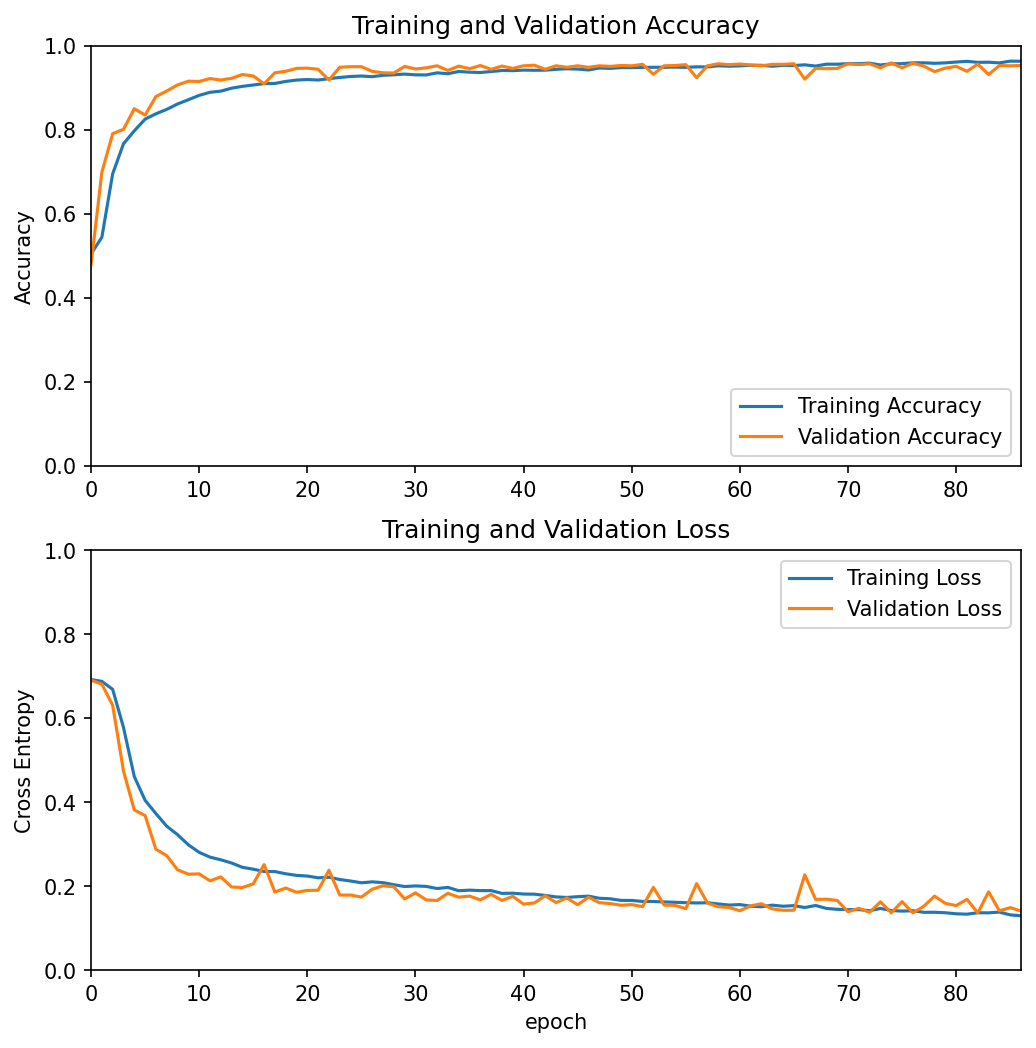

In [15]:
acc = history["binary_accuracy"]
val_acc = history["val_binary_accuracy"]

loss = history["loss"]
val_loss = history["val_loss"]

plt.figure(figsize=(8, 8), dpi=150)
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.xlim([0, len(history["binary_accuracy"]) - 1])
plt.ylim([0, 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.xlim([0, len(history["binary_accuracy"]) - 1])
plt.ylim([0, 1])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [16]:
test_set = tf.keras.utils.image_dataset_from_directory(
    "Dataset/extracted/test",
    seed=config["seed"],
    image_size=config["image_size"],
    batch_size=16,
    label_mode="binary",
)

AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_set.prefetch(buffer_size=AUTOTUNE)
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
test_labels = list(test_labels.flatten().astype("uint8"))

Found 2458 files belonging to 2 classes.


In [17]:
model = create_model(config)
checkpoint_dir = f"checkpoints/{model_filename}"
latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest_ckpt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4096)              2101248   
                                                      

In [18]:
y_pred = model.predict(test_dataset)

154/154 [==============================] - 5s 35ms/step


In [19]:
y_pred = y_pred.flatten()
y_pred = list(tf.where(y_pred < 0.5, 0, 1).numpy())

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

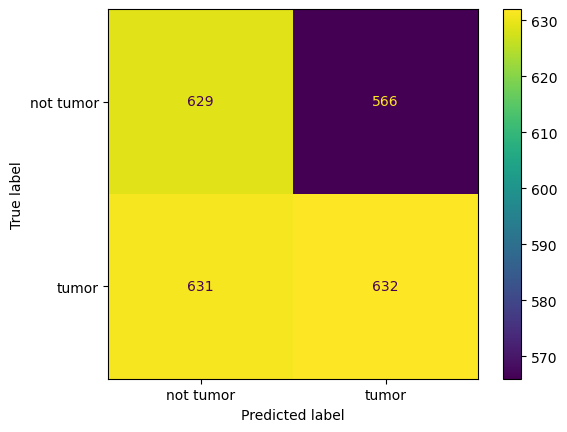

In [20]:
class_names = ["not tumor", "tumor"]

cm = confusion_matrix(y_true=test_labels, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

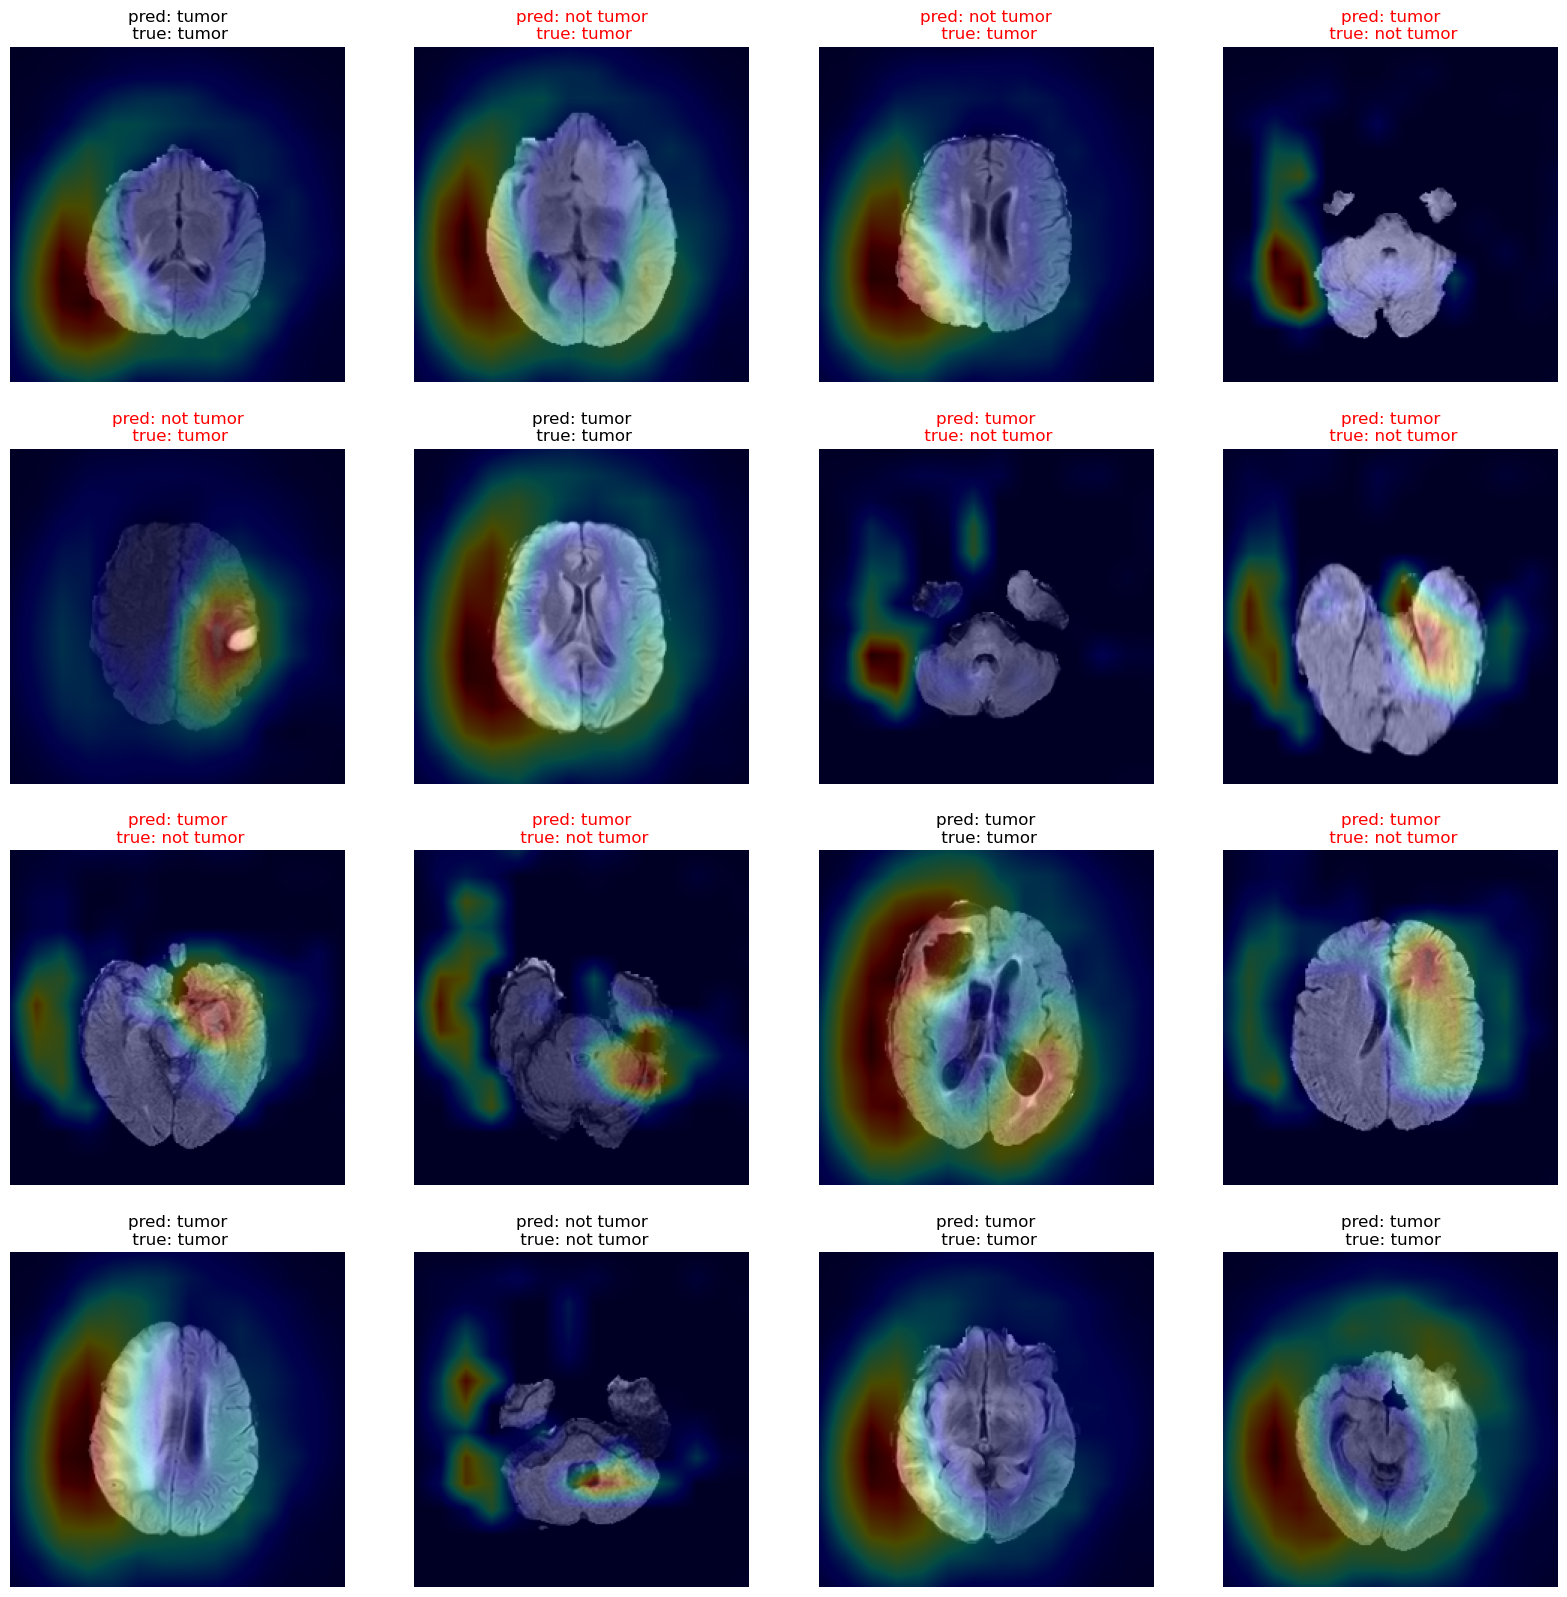

In [21]:
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.scorecam import Scorecam

image_batch, label_batch = test_dataset.as_numpy_iterator().next()

score = CategoricalScore(list(label_batch.flatten().astype("uint8")))

gradcam = GradcamPlusPlus(
    model.get_layer("vgg16"), model_modifier=ReplaceToLinear(), clone=True
)
# scorecam = Scorecam(model, model_modifier=ReplaceToLinear())
cam = gradcam(score, image_batch, penultimate_layer=-1)

plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.imshow(heatmap, cmap="jet", alpha=0.3)

    misclassified = (
        class_names[y_pred[i].astype("uint8")]
        == class_names[label_batch[i][0].astype("uint8")]
    )

    color = "black" if misclassified else "red"
    plt.title(
        f"pred: {class_names[y_pred[i].astype('uint8')]}\n true: {class_names[label_batch[i][0].astype('uint8')]}",
        color=color,
    )
    plt.axis("off")